In [2]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

sys.path.append("../utils")

import config

pd.set_option("display.max_columns", None)


In [4]:
def read_geojson_with_geopandas(file_path):
    gdf = gpd.read_file(file_path)
    return gdf


inspections_buffered_buildings_landcover = read_geojson_with_geopandas(
    "/capstone/wildfire_prep/data/MASTER_DATAFRAME/inspections_master.geojson"
)


In [5]:
inspections_buffered_buildings_landcover.dtypes

system_created                object
inspection_status             object
latitude                     float64
longitude                    float64
address_number                object
street                        object
apt_number                    object
city                          object
county                        object
zip_code                      object
address_full                  object
date                  datetime64[ms]
inspection_date               object
structure_type                object
year                           int32
address_id                     int32
maj_landcover_code           float64
geometry                    geometry
dtype: object

In [6]:
# landcover codes are coming in with the format '582.0', so let's make them integers
inspections_buffered_buildings_landcover["maj_landcover_code"] = (
    inspections_buffered_buildings_landcover["maj_landcover_code"].astype("Int64")
)

# make ZIP code an integer too
inspections_buffered_buildings_landcover["zip_code"] = (
    inspections_buffered_buildings_landcover["zip_code"].astype("Int64")
)

inspections_buffered_buildings_landcover.dtypes


system_created                object
inspection_status             object
latitude                     float64
longitude                    float64
address_number                object
street                        object
apt_number                    object
city                          object
county                        object
zip_code                       Int64
address_full                  object
date                  datetime64[ms]
inspection_date               object
structure_type                object
year                           int32
address_id                     int32
maj_landcover_code             Int64
geometry                    geometry
dtype: object

In [7]:
inspections_buffered_buildings_landcover.head()

,system_created,inspection_status,latitude,longitude,address_number,street,apt_number,city,county,zip_code,address_full,date,inspection_date,structure_type,year,address_id,maj_landcover_code,geometry
0,2019-05-07,Compliant,34.669616,-120.031160,3462,Brinkerhoff Rd,None,Santa Ynez,Santa Barbara,93460,3462 Brinkerhoff Rd Santa Ynez Santa Barbara C...,2019-06-05,2019-06-05,Utility or Miscellaneous Structure > 120 sqft,2019,1,304,"POLYGON ((-2161320.551 1564613.927, -2161341.6..."
1,2019-05-07,Compliant,34.679129,-120.091914,3290,Avenida Caballo,None,Santa Ynez,Santa Barbara,93460,3290 Avenida Caballo Santa Ynez Santa Barbara ...,2019-05-09,2019-05-09,Single Family Residence Multi Story,2019,2,304,"POLYGON ((-2166416.735 1566929.327, -2166519.5..."
2,2019-05-07,Compliant,34.676197,-120.089553,3350,Caballo Ln,None,Santa Ynez,Santa Barbara,93460,3350 Caballo Ln Santa Ynez Santa Barbara CA 93...,2019-05-09,2019-05-09,Single Family Residence Multi Story,2019,3,303,"POLYGON ((-2166360.165 1566692.606, -2166247.2..."
3,2019-05-07,Compliant,34.677982,-120.088944,3350,Caballo Ln,None,Santa Ynez,Santa Barbara,93460,3350 Caballo Ln Santa Ynez Santa Barbara CA 93...,2019-05-09,2019-05-09,Utility or Miscellaneous Structure > 120 sqft,2019,4,39,"POLYGON ((-2166289.215 1566761.998, -2166271.7..."
4,2019-05-07,Compliant,34.678469,-120.087539,3320 A,Canada Este Rd,None,Santa Ynez,Santa Barbara,93460,3320 A Canada Este Rd Santa Ynez Santa Barbara...,2019-12-17,2019-12-17,Single Family Residence Multi Story,2019,5,304,"POLYGON ((-2166019.677 1566870.269, -2166048.1..."


In [13]:
# dropping columns that would generate too many different labels with the label encoder. 

data1 = inspections_buffered_buildings_landcover.drop(
    columns=[
        "system_created",
        "latitude",
        "longitude",
        "address_number",
        "street",
        "apt_number",
        "city",
        "address_full",
        "date",
        "inspection_date",
        "geometry",
        "zip_code",
        "year",
        "address_id",
        "county",
    ]
)

In [14]:
data1.head()

,inspection_status,structure_type,maj_landcover_code
0,Compliant,Utility or Miscellaneous Structure > 120 sqft,304
1,Compliant,Single Family Residence Multi Story,304
2,Compliant,Single Family Residence Multi Story,303
3,Compliant,Utility or Miscellaneous Structure > 120 sqft,39
4,Compliant,Single Family Residence Multi Story,304


Code retrieved from Week 6 lab from EDS232, lab6-mammal-traits

In [15]:
categoricals = data1.select_dtypes(include=["object"])

for col in categoricals:
    le = LabelEncoder()
    data1[col] = le.fit_transform(data1[col].astype(str))

data1.head()


,inspection_status,structure_type,maj_landcover_code
0,0,16,304
1,0,13,304
2,0,13,303
3,0,16,39
4,0,13,304


Mean Squared Error: 0.005632646971053417


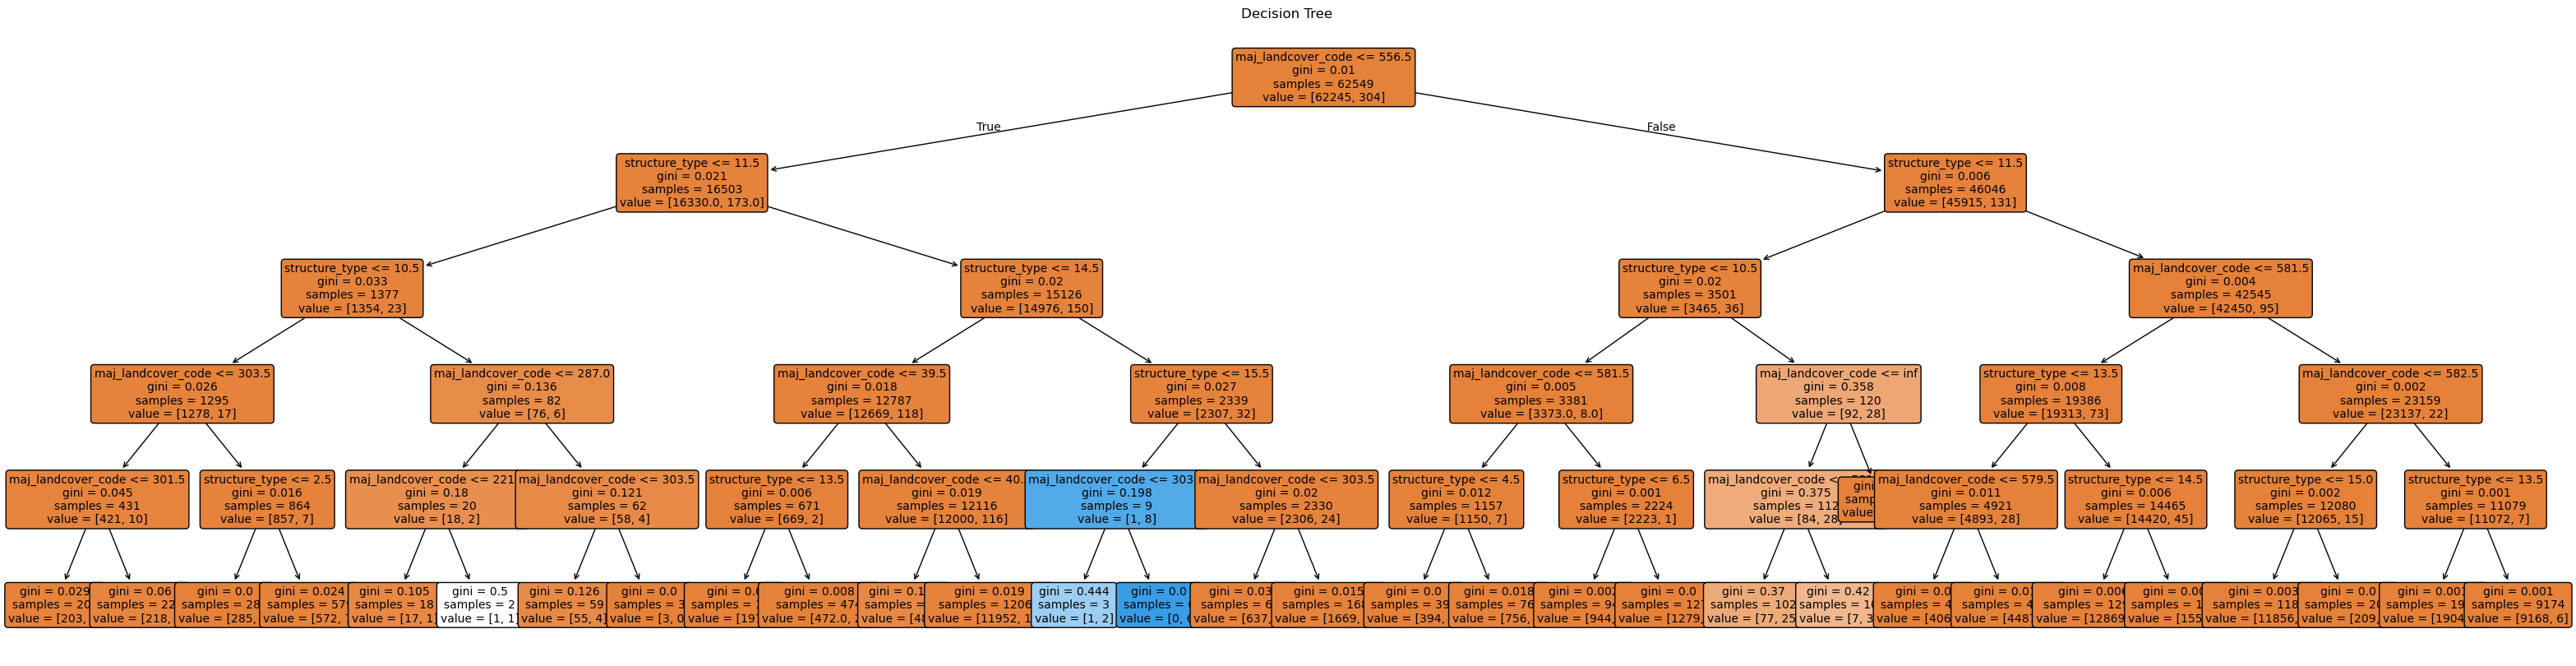

In [19]:
from sklearn.tree import DecisionTreeClassifier

X = data1.drop("inspection_status", axis=1)
y = data1["inspection_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=808
)

dt = DecisionTreeClassifier(max_depth=5, random_state=808)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.figure(figsize=(40, 10))
plot_tree(dt, filled=True, feature_names=X.columns, rounded=True, fontsize=10)
plt.title("Decision Tree")
plt.show()


In [20]:
param_grid = {
    "max_features": ["sqrt", 6, None],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf = RandomForestRegressor(random_state=808)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_split=10,
                      n_estimators=200, random_state=808)

Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
MSE on Test Set: 0.005416624944146587


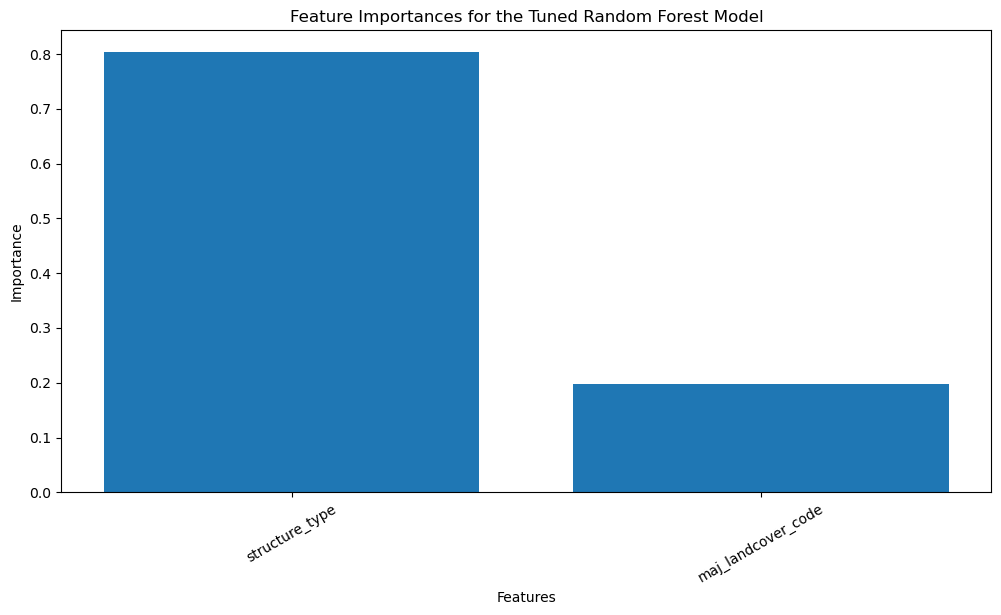

In [21]:
y_pred = best_rf.predict(X_test)

print("Best parameters:", grid_search.best_params_)

mse_value = mean_squared_error(y_test, y_pred)
print("MSE on Test Set:", mse_value)

importances = best_rf.feature_importances_

feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance["Feature"], feature_importance["Importance"])
plt.xticks(rotation=30)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances for the Tuned Random Forest Model")
plt.show()
